In [1]:
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

#define scenario input
analysis_year = 2050
shipment_load_attr = 'tons_' + str(analysis_year)
shipment_tonmile_attr = 'tmiles_' + str(analysis_year)
shipment_value_attr = 'value_' + str(analysis_year)

base_year = 2017
shipment_load_base = 'tons_' + str(base_year)
shipment_tonmile_base = 'tmiles_' + str(base_year)
shipment_value_base = 'value_' + str(base_year)

In [2]:
# load FAF5 data

faf_data = read_csv('validation/FAF5.3.csv', sep = ',')
print(faf_data.columns)

sctg_group_lookup = read_csv('SynthFirm_parameters/SCTG_Groups_revised.csv', sep = ',')
sctg_group_lookup.head(5)

cfs_faf_lookup = read_csv('SynthFirm_parameters/CFS_FAF_LOOKUP.csv')

Index(['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
       'tons_2018', 'tons_2019', 'tons_2020', 'tons_2022', 'tons_2023',
       'tons_2025', 'tons_2030', 'tons_2035', 'tons_2040', 'tons_2045',
       'tons_2050', 'value_2017', 'value_2018', 'value_2019', 'value_2020',
       'value_2022', 'value_2023', 'value_2025', 'value_2030', 'value_2035',
       'value_2040', 'value_2045', 'value_2050', 'current_value_2018',
       'current_value_2019', 'tmiles_2017', 'tmiles_2018', 'tmiles_2019',
       'tmiles_2020', 'tmiles_2022', 'tmiles_2023', 'tmiles_2025',
       'tmiles_2030', 'tmiles_2035', 'tmiles_2040', 'tmiles_2045',
       'tmiles_2050'],
      dtype='object')


In [3]:
faf_data.loc[:, 'mode_def'] = faf_data.loc[:, 'dms_mode'].map(mode_lookup)
faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')
faf_data.head(5)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050,mode_def,SCTG_Code,SCTG_Group,SCTG_Name,Description
0,NaN,11,11,NaN,NaN,1,NaN,1,1,1,...,5.327137,6.342501,7.763605,9.571647,11.343818,Truck,1,3,interm_food,Animals and Fish (live)
1,NaN,11,19,NaN,NaN,1,NaN,1,1,2,...,72.493059,82.113979,96.869428,116.602924,134.683927,Truck,1,3,interm_food,Animals and Fish (live)
2,NaN,11,129,NaN,NaN,1,NaN,1,1,3,...,0.533539,0.564126,0.638719,0.750361,0.844720,Truck,1,3,interm_food,Animals and Fish (live)
3,NaN,11,131,NaN,NaN,1,NaN,1,1,2,...,3.018065,3.155784,3.394250,3.850035,4.178881,Truck,1,3,interm_food,Animals and Fish (live)
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2,...,1.863748,1.969298,2.141527,2.456208,2.683008,Truck,1,3,interm_food,Animals and Fish (live)


In [4]:
# total production
aggr_var = [shipment_load_base, shipment_tonmile_base, shipment_value_base, 
            shipment_load_attr, shipment_tonmile_attr, shipment_value_attr]
faf_production = faf_data.groupby(['dms_orig', 'SCTG_Code', 'SCTG_Name'])[aggr_var].sum()
faf_production = faf_production.reset_index()

converstion_factor = 10**6/(1000*2000) # $/lb
value_density_base = 'value_density_' + str(base_year)
value_density_attr = 'value_density_' + str(analysis_year)

faf_production.loc[:, value_density_base] = faf_production.loc[:, shipment_value_base] * converstion_factor / \
faf_production.loc[:, shipment_load_base]

faf_production.loc[:, value_density_attr] = faf_production.loc[:, shipment_value_attr] * converstion_factor / \
faf_production.loc[:, shipment_load_attr]

print(len(faf_production))
print(len(faf_production.dms_orig.unique()))
faf_production.head(5)

5490
132


,dms_orig,SCTG_Code,SCTG_Name,tons_2017,tmiles_2017,value_2017,tons_2050,tmiles_2050,value_2050,value_density_2017,value_density_2050
0,11,1,interm_food,659.199914,104.607515,862.102053,1815.401825,276.404498,2374.362172,0.653900,0.653949
1,11,2,bulk,67.391090,10.090577,7.933821,59.040127,8.711642,6.995701,0.058864,0.059245
2,11,3,interm_food,625.191277,109.053255,262.004137,823.411300,154.491646,350.577260,0.209539,0.212881
3,11,4,interm_food,516.931136,161.517914,191.213345,1089.708954,365.207922,372.609223,0.184951,0.170967
4,11,5,interm_food,478.256176,187.469394,951.022476,521.382663,217.373517,1075.202390,0.994261,1.031107


0    2.753947
1    0.876082
2    1.317055
3    2.108035
4    1.090174
Name: growth_factor, dtype: float64

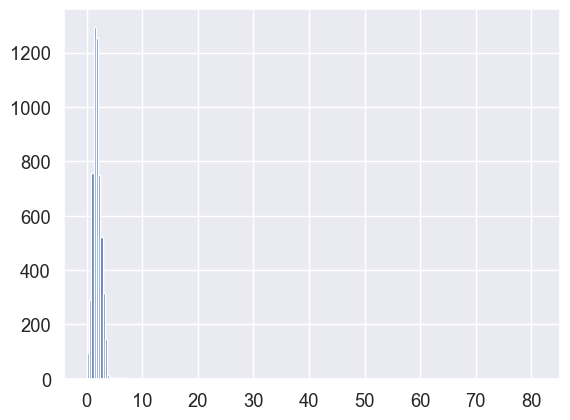

In [5]:
faf_production.loc[:, 'growth_factor'] = \
faf_production.loc[:, shipment_load_attr] / faf_production.loc[:, shipment_load_base]
faf_production.loc[:, 'growth_factor'].hist(bins = 200)
# plt.xlim([0,50])
faf_production.loc[:, 'growth_factor'].head(5)

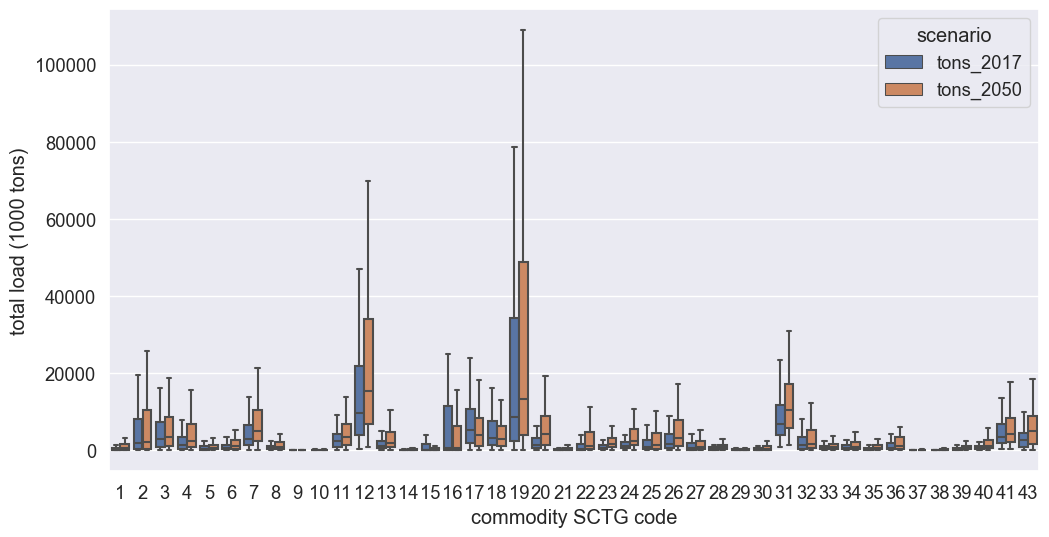

In [6]:
# plot production variation
faf_production_long = pd.melt(faf_production, 
                              id_vars=['dms_orig', 'SCTG_Code'], 
                              value_vars=[shipment_load_base, shipment_load_attr], 
                              var_name='scenario', 
                              value_name='tonnage')

faf_production_long = faf_production_long.reset_index()
plt.figure(figsize = (12,6))
sns.boxplot(data = faf_production_long, x="SCTG_Code", y="tonnage", 
            hue="scenario", showfliers = False)
plt.ylabel('total load (1000 tons)')
plt.xlabel('commodity SCTG code')
plt.show()

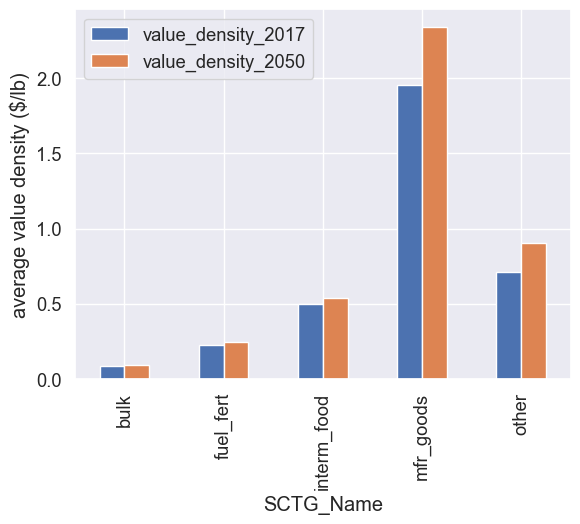

In [7]:
faf_production_tonnage_agg = \
faf_production.groupby(['SCTG_Name'])[[shipment_load_base, shipment_load_attr, 
                                       shipment_value_base, shipment_value_attr]].sum()
faf_production_tonnage_agg.loc[:, value_density_base] = faf_production_tonnage_agg.loc[:, shipment_value_base] * converstion_factor / \
faf_production_tonnage_agg.loc[:, shipment_load_base]

faf_production_tonnage_agg.loc[:, value_density_attr] = faf_production_tonnage_agg.loc[:, shipment_value_attr] * converstion_factor / \
faf_production_tonnage_agg.loc[:, shipment_load_attr]

# faf_production_tonnage_agg[[shipment_load_base, shipment_load_attr]].plot(kind = 'bar')
# plt.ylabel('total production (1000 tons)')
# plt.show()

faf_production_tonnage_agg[[value_density_base, value_density_attr]].plot(kind = 'bar')
plt.ylabel('average value density ($/lb)')
plt.show()

In [8]:
# process attraction
faf_attraction = faf_data.groupby(['dms_dest', 'SCTG_Code', 'SCTG_Name'])[aggr_var].sum()
faf_attraction = faf_attraction.reset_index()

faf_attraction.loc[:, value_density_base] = faf_attraction.loc[:, shipment_value_base] * converstion_factor / \
faf_attraction.loc[:, shipment_load_base]

faf_attraction.loc[:, value_density_attr] = faf_attraction.loc[:, shipment_value_attr] * converstion_factor / \
faf_attraction.loc[:, shipment_load_attr]

print(len(faf_attraction))
print(len(faf_attraction.dms_dest.unique()))
faf_attraction.head(5)

5487
132


,dms_dest,SCTG_Code,SCTG_Name,tons_2017,tmiles_2017,value_2017,tons_2050,tmiles_2050,value_2050,value_density_2017,value_density_2050
0,11,1,interm_food,831.591621,108.478818,1172.637390,2733.443729,356.047491,3852.750100,0.705056,0.704743
1,11,2,bulk,293.993643,109.671537,48.903420,260.441080,104.881898,52.768493,0.083171,0.101306
2,11,3,interm_food,271.512814,272.156734,458.721012,279.325458,326.865551,606.237271,0.844750,1.085181
3,11,4,interm_food,847.716449,183.601632,596.214136,1500.801788,343.585054,1042.917722,0.351659,0.347454
4,11,5,interm_food,295.418043,99.853421,872.660916,435.927208,146.248423,1255.511578,1.476993,1.440047


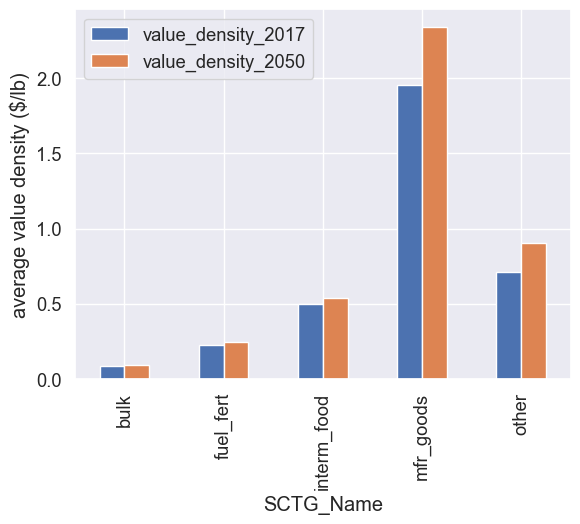

In [9]:
faf_attraction_tonnage_agg = \
faf_attraction.groupby(['SCTG_Name'])[[shipment_load_base, shipment_load_attr, 
                                       shipment_value_base, shipment_value_attr]].sum()
faf_attraction_tonnage_agg.loc[:, value_density_base] = faf_attraction_tonnage_agg.loc[:, shipment_value_base] * converstion_factor / \
faf_attraction_tonnage_agg.loc[:, shipment_load_base]

faf_attraction_tonnage_agg.loc[:, value_density_attr] = faf_attraction_tonnage_agg.loc[:, shipment_value_attr] * converstion_factor / \
faf_attraction_tonnage_agg.loc[:, shipment_load_attr]

# faf_attraction_tonnage_agg[[shipment_load_base, shipment_load_attr]].plot(kind = 'bar')
# plt.ylabel('total attraction (1000 tons)')
# plt.show()

faf_attraction_tonnage_agg[[value_density_base, value_density_attr]].plot(kind = 'bar')
plt.ylabel('average value density ($/lb)')
plt.show()

In [10]:
# saving output
production_output_attr = ['dms_orig', 'SCTG_Code',	shipment_load_attr, value_density_attr]
attraction_output_attr = ['dms_dest', 'SCTG_Code',	shipment_load_attr, value_density_attr]

faf_production_output = faf_production[production_output_attr]
faf_attraction_output = faf_attraction[attraction_output_attr]

faf_production_output.to_csv('SynthFirm_parameters/total_commodity_production_' + str(analysis_year) + '.csv', sep = ',', index = False)
faf_attraction_output.to_csv('SynthFirm_parameters/total_commodity_attraction_' + str(analysis_year) + '.csv', sep = ',', index = False)

In [11]:
# generate unit cost
# faf_production_output.head(5)
unit_cost_forecast = faf_production_output[['dms_orig', 'SCTG_Code', value_density_attr]]

unit_cost_forecast = pd.merge(unit_cost_forecast, cfs_faf_lookup,
                              left_on = 'dms_orig', right_on = 'FAF',
                              how = 'left')
unit_cost_forecast = unit_cost_forecast[['ST_MA', 'SCTG_Code', value_density_attr]]
unit_cost_forecast[value_density_attr] *= 2000 # convert to $/us ton
unit_cost_forecast = \
unit_cost_forecast.rename(columns = {'ST_MA': 'ORIG_CFS_AREA',
                                     'SCTG_Code': 'Commodity_SCTG',
                                    value_density_attr: 'UnitCost'})
unit_cost_forecast.to_csv('SynthFirm_parameters/data_unitcost_by_zone_faf' + str(analysis_year) + '.csv', sep = ',', index = False)